In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

In [3]:
def _gf_colorgray(I, p, r, eps, s=None):
    """ automatically choose color or gray guided filter based on I's shape """
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print("Invalid guide dimensions:", I.shape)

In [4]:
def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q


In [5]:
def _gf_color(I, p, r, eps, s=None):
    """ Color guided filter
    I - guide image (rgb)
    p - filtering input (single channel)
    r - window radius
    eps - regularization (roughly, variance of non-edge noise)
    s - subsampling factor for fast guided filter
    """
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    #       rr rg rb
    #       rg gg gb
    #       rb gb bb
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q


In [6]:
def guided_filter(I, p, r, eps, s=None):
    """ run a guided filter per-channel on filtering input p
        I - guide image (1 or 3 channel)
        p - filter input (n channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if p.ndim == 2:
        p3 = p[:,:,np.newaxis]

    out = np.zeros_like(p)
    for ch in range(p.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out

In [42]:
aush = cv.imread('P8/aush.png')
aush = cv.cvtColor(aush, cv.COLOR_BGR2GRAY)

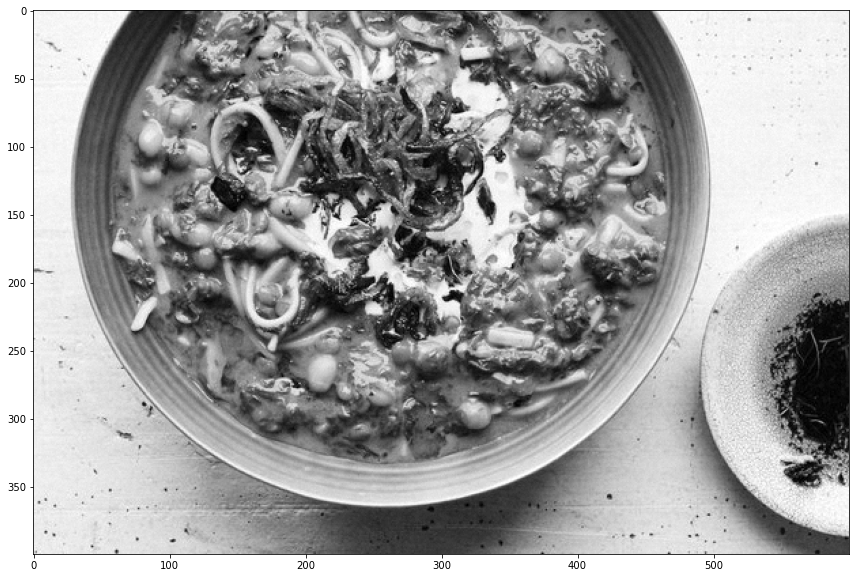

In [43]:
from skimage import io, img_as_float
n_aush = img_as_float(aush)
image = img_as_float(aush)
noise = np.random.normal(0, 0.01, image.shape)
noisy = image + noise
noisy = np.clip(noisy, 0.0,1.0)
plt.figure(figsize=(20,10))
plt.imshow(noisy,cmap='gray')

In [28]:
filtered_aush_1 = _gf_gray(noisy, noisy, 2, 0.01)
filtered_aush_2 = _gf_gray(noisy, noisy, 2, 0.04)
filtered_aush_3 = _gf_gray(noisy, noisy, 2, 0.16)
filtered_aush_4 = _gf_gray(noisy, noisy, 4, 0.01)
filtered_aush_5 = _gf_gray(noisy, noisy, 4, 0.04)
filtered_aush_6 = _gf_gray(noisy, noisy, 4, 0.16)
filtered_aush_7 = _gf_gray(noisy, noisy, 8, 0.01)
filtered_aush_8 = _gf_gray(noisy, noisy, 8, 0.04)
filtered_aush_9 = _gf_gray(noisy, noisy, 8, 0.16)

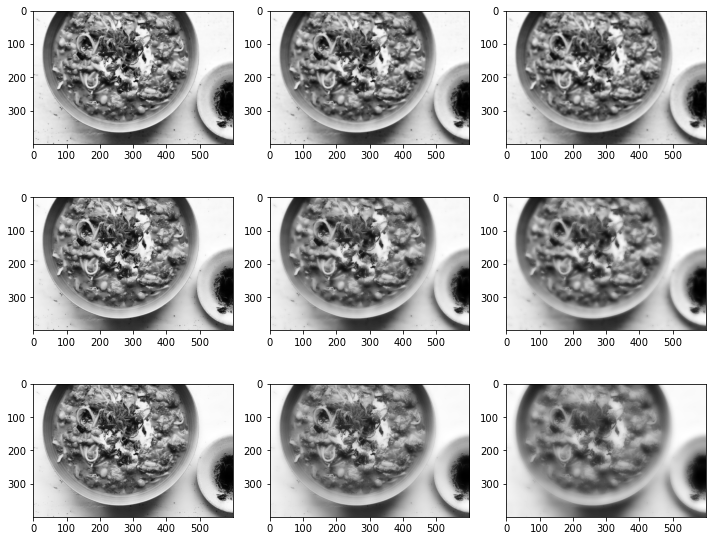

In [30]:
fig, axes = plt.subplots(ncols=3, nrows=3)
fig.set_size_inches(10, 8)
axes = axes.ravel()
axes[0].imshow(filtered_aush_1,cmap = 'gray')
axes[1].imshow(filtered_aush_2,cmap = 'gray')
axes[2].imshow(filtered_aush_3,cmap = 'gray')
axes[3].imshow(filtered_aush_4,cmap = 'gray')
axes[4].imshow(filtered_aush_5,cmap = 'gray')
axes[5].imshow(filtered_aush_6,cmap = 'gray')
axes[6].imshow(filtered_aush_7,cmap = 'gray')
axes[7].imshow(filtered_aush_8,cmap = 'gray')
axes[8].imshow(filtered_aush_9,cmap = 'gray')

fig.tight_layout()
plt.show()

In [46]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5] 
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')
        
def psnr(img1, img2):
    
    mse = np.mean( (img1 - img2) ** 2 )

    PIXEL_MAX = 255.0
    
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

# part a

In [51]:
psnr_1 = psnr(aush,filtered_aush_1)
psnr_2 = psnr(aush,filtered_aush_2)
psnr_3 = psnr(aush,filtered_aush_3)
psnr_4 = psnr(aush,filtered_aush_4)
psnr_5 = psnr(aush,filtered_aush_5)
psnr_6 = psnr(aush,filtered_aush_6)
psnr_7 = psnr(aush,filtered_aush_7)
psnr_8 = psnr(aush,filtered_aush_8)
psnr_9 = psnr(aush,filtered_aush_9)

In [52]:
psnr_list = [psnr_1,psnr_2,psnr_3,psnr_4,psnr_5,psnr_6,psnr_7,psnr_8,psnr_9]
print(psnr_1)
print(psnr_2)
print(psnr_3)
print(psnr_4)
print(psnr_5)
print(psnr_6)
print(psnr_7)
print(psnr_8)
print(psnr_9)

3.726421222104004
3.7262263322263434
3.726068846906005
3.7263380084225446
3.7260192127634224
3.7257344105743586
3.726249616477336
3.7257678821873657
3.7252892929298893


In [53]:
psnr_list = np.array(psnr_list)
np.argmax(psnr_list)

0

# the best parameter based on psnr is r = 2 and eps = 0.01

In [54]:
psnr_1 = calculate_ssim(aush,filtered_aush_1)
psnr_2 = calculate_ssim(aush,filtered_aush_2)
psnr_3 = calculate_ssim(aush,filtered_aush_3)
psnr_4 = calculate_ssim(aush,filtered_aush_4)
psnr_5 = calculate_ssim(aush,filtered_aush_5)
psnr_6 = calculate_ssim(aush,filtered_aush_6)
psnr_7 = calculate_ssim(aush,filtered_aush_7)
psnr_8 = calculate_ssim(aush,filtered_aush_8)
psnr_9 = calculate_ssim(aush,filtered_aush_9)
psnr_list = [psnr_1,psnr_2,psnr_3,psnr_4,psnr_5,psnr_6,psnr_7,psnr_8,psnr_9]

In [55]:
print(psnr_1)
print(psnr_2)
print(psnr_3)
print(psnr_4)
print(psnr_5)
print(psnr_6)
print(psnr_7)
print(psnr_8)
print(psnr_9)

0.0031964491539346876
0.0031949667352703316
0.003194316326760789
0.0032091894183208566
0.003218004002794392
0.0032258793481610756
0.003230009114833976
0.003264792380222056
0.0032993127177481855


In [56]:
psnr_list = np.array(psnr_list)
np.argmax(psnr_list)

8

# the best parameter based on ssim is r = 8 and eps = 0.16

# part b

In [70]:
psnr_list = []
ssim_list = []
img_list = []
for i in range(1,51):
    filtered_aush_1 = _gf_gray(noisy, noisy, i, 0.04)
    img_list.append(filtered_aush_1)
    cs = ssim(aush,filtered_aush_1)
    ssim_list.append(cs)
    ps = psnr(aush,filtered_aush_1)
    psnr_list.append(ps)

In [71]:
psnr_list = np.array(psnr_list)
np.argmax(psnr_list)

0

In [72]:
ssim_list = np.array(ssim_list)
np.argmax(ssim_list)

49

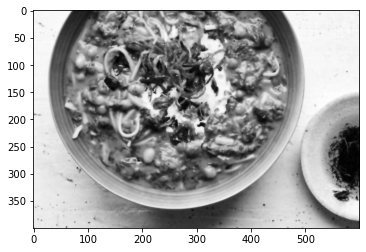

In [73]:
plt.imshow(img_list[0],cmap='gray')

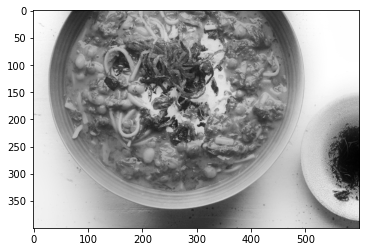

In [74]:
plt.imshow(img_list[25],cmap='gray')

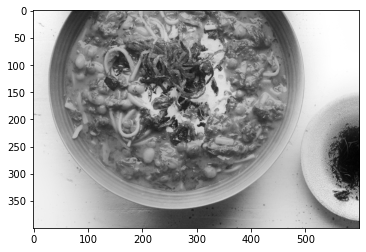

In [76]:
plt.imshow(img_list[30],cmap='gray')

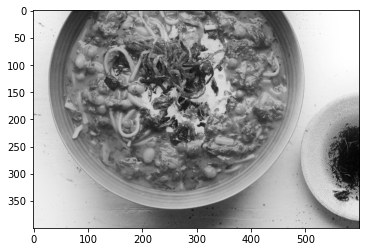

In [77]:
plt.imshow(img_list[41],cmap='gray')

# به نظر میرسد با افزایش شعاع ابتدا میزان تاری افزایش پیدا میکند ولی در ادامه دوباره لبه ها بازیابی میشوند به عنوان مثال به تصویر 41 و 25 دقت کنید

In [84]:
psnr_list = []
ssim_list = []
img_list = []
for i in range(1,100):
    filtered_aush_1 = _gf_gray(noisy, noisy, 4, 0.01*i)
    img_list.append(filtered_aush_1)
    cs = ssim(aush,filtered_aush_1)
    ssim_list.append(cs)
    ps = psnr(aush,filtered_aush_1)
    psnr_list.append(ps)

In [79]:
psnr_list = np.array(psnr_list)
np.argmax(psnr_list)

0

In [80]:
ssim_list = np.array(ssim_list)
np.argmax(ssim_list)

49

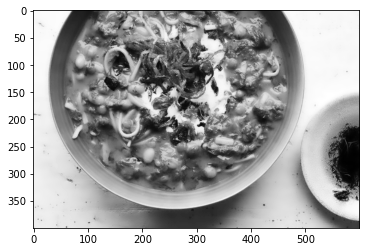

In [81]:
plt.imshow(img_list[0],cmap='gray')

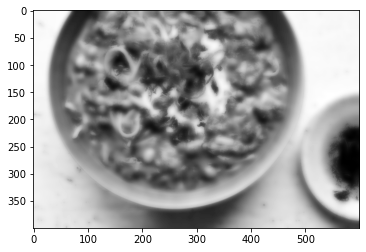

In [82]:
plt.imshow(img_list[25],cmap='gray')

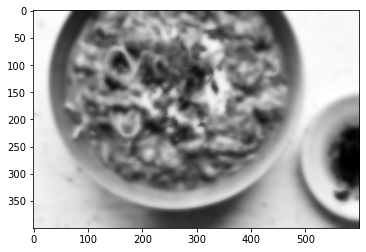

In [83]:
plt.imshow(img_list[49],cmap='gray')

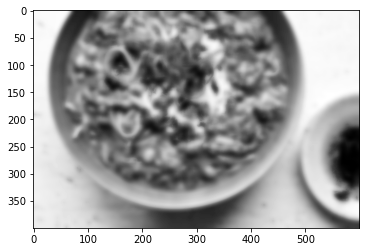

In [86]:
plt.imshow(img_list[98],cmap='gray')

# به نظر میرسد با افزایش اپسیلون میزان تاری افزایش پیدا میکند ولی بعد از یک مقداری به نوعی به اشباع میرسد.

# part c

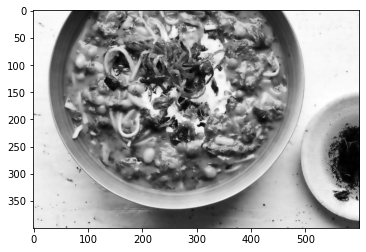

In [87]:
filtered_aush_1 = _gf_gray(noisy, noisy, 2, 0.01)
plt.imshow(filtered_aush_1,cmap='gray')

In [88]:
cs = ssim(aush,filtered_aush_1)
print('ssim:'+str(cs))

ssim:0.0031964491539346876


In [89]:
ps = psnr(aush,filtered_aush_1)
print('psnr:'+str(ps))

psnr:3.726421222104004


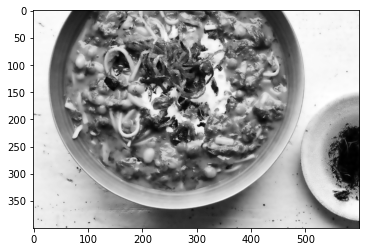

In [44]:
#guid image without noise
filtered_aush_1 = _gf_gray(n_aush, noisy, 2, 0.01)
plt.imshow(filtered_aush_1,cmap='gray')

In [47]:
cs = ssim(aush,filtered_aush_1)
print('ssim:'+str(cs))

ssim:0.0031965974105125808


In [48]:
ps = psnr(aush,filtered_aush_1)
print('psnr:'+str(ps))

psnr:3.7264240908070057


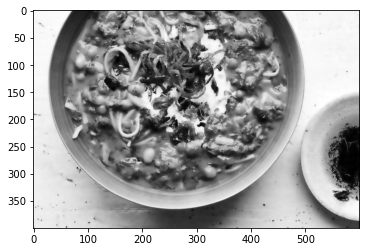

In [49]:
#guid image with noise
filtered_aush_1 = _gf_gray(noisy, noisy, 2, 0.01)
plt.imshow(filtered_aush_1,cmap='gray')

In [50]:
cs = ssim(aush,filtered_aush_1)
print('ssim:'+str(cs))

ssim:0.0031966534770448978


In [51]:
ps = psnr(aush,filtered_aush_1)
print('psnr:'+str(ps))

psnr:3.726425167789291


# در صورتی که از تصویز بدون نویز برای ورودی تصویر راهنما استفاده کنیم نتیجه از نظر دید انسان تفاوتی ندارد ولی از نظر پی سی ان آر تفاوت جزئی دارد و اگر تصویر راهنما و ورودی یکی باشد پی اس ان آر خیلی کم بهتر است در حد رقم ششم اعشار درمورد اس اس آی ام هم همینطور.

# part d

In [178]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math


def convolution(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))

    print("Kernel Shape : {}".format(kernel.shape))

    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()

    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))

    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()

    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]

    print("Output Image size : {}".format(output.shape))

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()

    return output

def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)


def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()

    return kernel_2D


def gaussian_blur(image, kernel_size,sigma ,verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma, verbose=verbose)
    return convolution(image, kernel, average=True, verbose=verbose)

Image Shape : (400, 600)
Kernel Shape : (3, 3)
Output Image size : (400, 600)


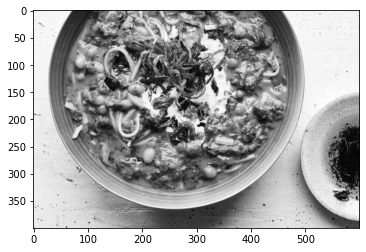

In [183]:
img = gaussian_blur(noisy, 3,0.01)
plt.imshow(img,cmap='gray')

In [184]:
cs = ssim(aush,img)
print('ssim:'+str(cs))

ssim:0.0008519003324159113


In [185]:
ps = psnr(aush,blur)
print('psnr:'+str(ps))

psnr:3.72632523959618


# همانطور که مشخص است با اندازه کرنل 3 و سیگمای 0.01 تصویر دینویز میشود، برای حالت کرنل گوسی پی اس ان آر برابر 3.7263 است و برای حالت فیلر با راهنما3.7264 که در نتیجه فیترینگ با راهنما کمی بهتر عمل کرده است.

# part e

In [263]:
date = cv.imread('P8/date.png')
date_gray = cv.cvtColor(date, cv.COLOR_BGR2GRAY)
date_gray = np.clip(date_gray, 0.0,1.0)
date_colored = cv.cvtColor(date, cv.COLOR_BGR2RGB)

In [264]:
image = img_as_float(date_colored)
noise = np.random.normal(0, 0.2, image.shape)
noisy = image + noise
noisy = np.clip(noisy, 0.0,1.0)

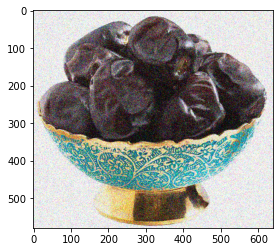

In [267]:
plt.imshow(noisy)

In [277]:
eps_list = [0.01,0.04,0.03,0.016]
r_list = [2,4,6,8,10,12,14,16]
img_list = []
psnr_list = []
ssim_list = []
param_list = []

for r in r_list:
    for eps in eps_list:
        channel_1 = guided_filter(date_gray, noisy, r, eps)
        img_list.append(channel_1)
        ssi= calculate_ssim(date_colored, channel_1)
        ssim_list.append(ssi)
        ps = psnr(date_colored, channel_1)
        psnr_list.append(ps)
        param_list.append([r,eps])

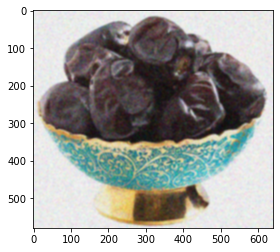

In [269]:
psnr_list = np.array(psnr_list)
index = np.argmax(psnr_list)
best_params = param_list[index]
plt.imshow(img_list[index])

In [270]:
print('best parameter:'+str(best_params))

best parameter:[2, 0.01]


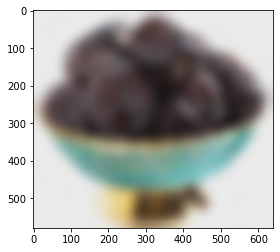

In [278]:
plt.imshow(img_list[-1])

In [271]:
eps_list = [0.01,0.04,0.03,0.016]
r_list = [2,4,6,8,10,12,14,16]
img_list = []
psnr_list = []
ssim_list = []
param_list = []

for r in r_list:
    for eps in eps_list:
        channel_1 = guided_filter(noisy, noisy, r, eps)
        img_list.append(channel_1)
        ssi= calculate_ssim(date_colored, channel_1)
        ssim_list.append(ssi)
        ps = psnr(date_colored, channel_1)
        psnr_list.append(ps)
        param_list.append([r,eps])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


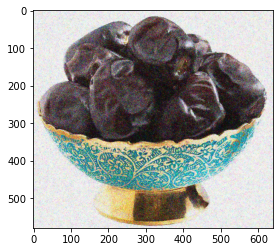

In [272]:
psnr_list = np.array(psnr_list)
index = np.argmax(psnr_list)
best_params = param_list[index]
plt.imshow(img_list[index])

In [273]:
print('best parameter:'+str(best_params))

best parameter:[2, 0.01]


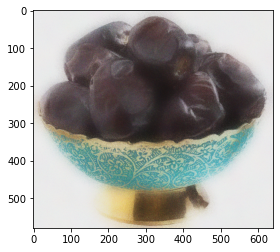

In [279]:
plt.imshow(guided_filter(noisy, noisy, 16, 0.16))

In [281]:
psnr(guided_filter(noisy, noisy, 16, 0.16),date_colored)

2.9789605699507855

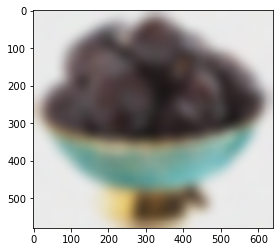

In [280]:
plt.imshow(guided_filter(date_gray, noisy, 16, 0.16))

In [282]:
psnr(guided_filter(date_gray, noisy, 16, 0.16),date_colored)

2.9783242975080535

# همانطور که مشاهده میشود تفاوت این دوحالت یعنی حالتی که از تصویر خاکستری به عنوان تصویر راهنما استفاده میشود و حالتی که از خود تصویر به عنوان تصور راهنما استفاده میشود تنها در حالات غیر بهنیه است یعنی در حالت بهینه از نظر معیار پی اسن ان آر تفاوت بسیار کمی داریم ولی در حالتی که اپسیلون زیاد میشود میزان تاری در حال خاکستری بیشتر است ، عباوه بر این پی اس ان آر برای حالتی که از تصویر ورودی به عنوان تصویر راهنما استفاده میکنیم بیشتر است، البته طبیعیست چون هنگام استفاده از تصویر رنگی هر کانال با مقادیر دقیق متناظر در تصویر راهنما مقایسه میشود و ضرایب دقیقتر بدست میایند.. 

# part h

In [22]:
from skimage import io, img_as_float

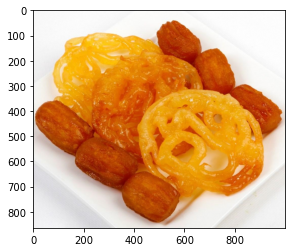

In [25]:
zoolbia_bamieh = cv.imread('P8/zoolbia_bamieh.png')
zoolbia_bamieh = cv.cvtColor(zoolbia_bamieh, cv.COLOR_BGR2RGB)
image = img_as_float(zoolbia_bamieh)
zoolbia_bamieh = np.clip(image, 0.0,1.0)
plt.imshow(zoolbia_bamieh)


In [26]:
q = guided_filter(zoolbia_bamieh, zoolbia_bamieh, 4, 0.04)

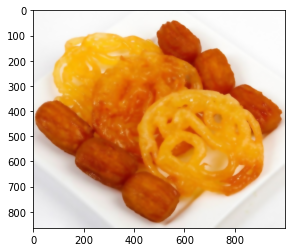

In [34]:
plt.imshow(q)

In [27]:
d = cv.absdiff(zoolbia_bamieh,q)

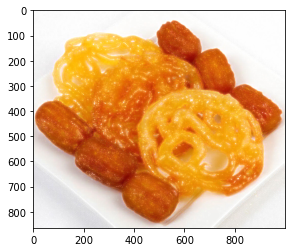

In [31]:
alpha = 3
p_enh = q+alpha*d 
p_enh = img_as_float(p_enh)
p_enh  = np.clip(p_enh , 0.0,1.0)
plt.imshow(p_enh)

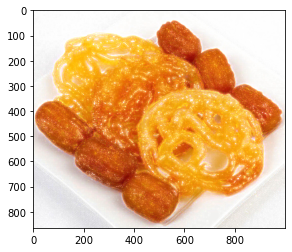

In [32]:
alpha = 5
p_enh = q+alpha*d 
p_enh = img_as_float(p_enh)
p_enh  = np.clip(p_enh , 0.0,1.0)
plt.imshow(p_enh)

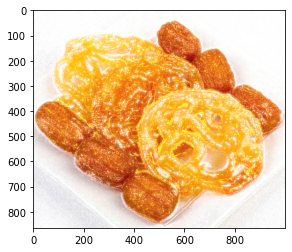

In [33]:
alpha = 10
p_enh = q+alpha*d 
p_enh = img_as_float(p_enh)
p_enh  = np.clip(p_enh , 0.0,1.0)
plt.imshow(p_enh)

# همانطور که از تصاویر بالا مشخص است، با افزایش ضریب آلفا لبه ها تقویت میشوند و از یک نقطه به بعد حالت غیرعادی به خود میگیرند

# part i

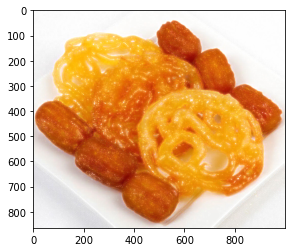

In [35]:
q = guided_filter(zoolbia_bamieh, zoolbia_bamieh, 3, 0.04)
d = cv.absdiff(zoolbia_bamieh,q)
alpha = 3
p_enh = q+alpha*d 
p_enh = img_as_float(p_enh)
p_enh  = np.clip(p_enh , 0.0,1.0)
plt.imshow(p_enh)

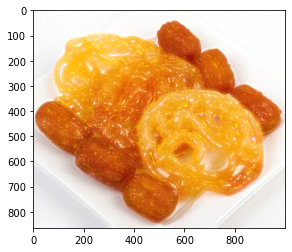

In [36]:
q = guided_filter(zoolbia_bamieh, zoolbia_bamieh, 9, 0.04)
d = cv.absdiff(zoolbia_bamieh,q)
alpha = 3
p_enh = q+alpha*d 
p_enh = img_as_float(p_enh)
p_enh  = np.clip(p_enh , 0.0,1.0)
plt.imshow(p_enh)

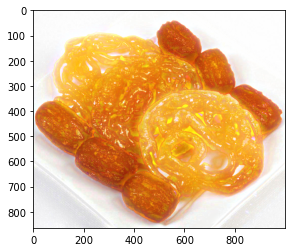

In [37]:
q = guided_filter(zoolbia_bamieh, zoolbia_bamieh, 21, 0.04)
d = cv.absdiff(zoolbia_bamieh,q)
alpha = 3
p_enh = q+alpha*d 
p_enh = img_as_float(p_enh)
p_enh  = np.clip(p_enh , 0.0,1.0)
plt.imshow(p_enh)

# به نظر میرسد افزایش شعاع سبب تقویت لبه ها میشود ولی از یک نقطه به بعد حالت غیر طبیعی به نتیجه میدهد.

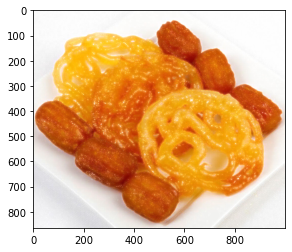

In [38]:
q = guided_filter(zoolbia_bamieh, zoolbia_bamieh, 3, 0.04)
d = cv.absdiff(zoolbia_bamieh,q)
alpha = 3
p_enh = q+alpha*d 
p_enh = img_as_float(p_enh)
p_enh  = np.clip(p_enh , 0.0,1.0)
plt.imshow(p_enh)

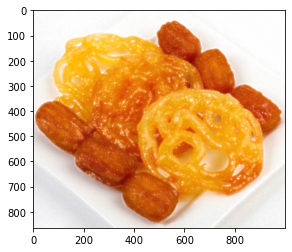

In [39]:
q = guided_filter(zoolbia_bamieh, zoolbia_bamieh, 3, 0.16)
d = cv.absdiff(zoolbia_bamieh,q)
alpha = 3
p_enh = q+alpha*d 
p_enh = img_as_float(p_enh)
p_enh  = np.clip(p_enh , 0.0,1.0)
plt.imshow(p_enh)

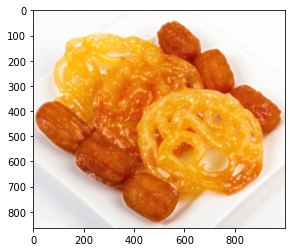

In [40]:
q = guided_filter(zoolbia_bamieh, zoolbia_bamieh, 3, 0.32)
d = cv.absdiff(zoolbia_bamieh,q)
alpha = 3
p_enh = q+alpha*d 
p_enh = img_as_float(p_enh)
p_enh  = np.clip(p_enh , 0.0,1.0)
plt.imshow(p_enh)

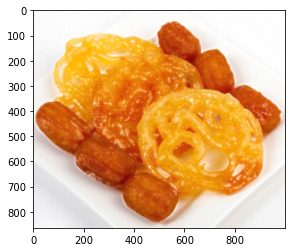

In [41]:
q = guided_filter(zoolbia_bamieh, zoolbia_bamieh, 3, 2)
d = cv.absdiff(zoolbia_bamieh,q)
alpha = 3
p_enh = q+alpha*d 
p_enh = img_as_float(p_enh)
p_enh  = np.clip(p_enh , 0.0,1.0)
plt.imshow(p_enh)

# به نظر میرسد اپسیلون تاثیر زیادی در نتایج نداردو تغییر آلفا تاثیر از همه بیشتری روی نتایج دارد